Author: Anastasios (Andy) Tzanidakis

If you have any questions in regards to the following tutorial or code, contact [Andy Tzanidakis](at3156@columbia.edu) 

In [4]:
from astropy.table import Table
from astropy.io import ascii, fits
import numpy as np
import scipy.io
from galpy.util import bovy_coords
from galpy import util
from scipy import stats
from astropy import units as u
import astropy.coordinates as coord
from pyia import GaiaData
import gala.coordinates as gc
import healpy as hp
from astropy import coordinates
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

### Hepler Functions -

In [5]:
def distance_add(j0, ks0, a_ks0, feh):
    """
    Will estimate the distance for RGB stars given photometry and metellicity in 2MASS
    
    """
    
    # First define color 
    jk0 = j0-ks0 # (J-Ks)0 color 
    
    # Derive absolute magnitude in Ks_band -- equation by Sheffield et al. 2014
    M_ks0 = (3.8+1.3*feh) - 8.4*jk0
    
    dm = (ks0-M_ks0+5-a_ks0)/5
    distance = 10**(dm)
    
    return (distance/1000) # in kpc

def Table_load(data, feh=-1):

    # Distance calculator -- assuming that metalicity is [Fe/H] = -1 
    distance = distance_add(data['j0'], data['ks0'], data['A_ks'], feh)
    
    l, b, distance = data['l'], data['b'], distance
    parallax, parallax_error = data['parallax'], data['parallax_error']
    pmra, pmdec = data['pmra'], data['pmdec']
    pmra_error, pmdec_error = data['pmra_error'], data['pmdec_error']
    g_mag, BP, RP = data['g_mag'], data['BP'], data['RP']
    ks0, j0, h0 = data['ks0'], data['j0'], data['h0']
    
    
    Tables = Table([l,b,distance,parallax,parallax_error, pmra, pmdec,pmra_error, pmdec_error,g_mag,BP,RP,ks0,j0,h0],
                 names=('l', 'b', 'distance', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'pmra_error',
                       'pmdec_error', 'g_mag', 'BP', 'RP', 'ks0', 'j0', 'h0'))
    return (Tables)

def cat2hpx(lon, lat, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates
    """
    npix = hp.nside2npix(nside)
    
    if radec:
        eq = SkyCoord(lon, lat, 'icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    
    return hpx_map
    

### Unpack data & load variables - 

In [17]:
# Load .fits file 
data = fits.open("rgb_data.fits")

# Extrapolate data + add distance 
data = Table_load.(data[1].data)

# Spatial Variales (l, b, distance)
l, b, dist = data['l'], data['b'], data['distance']
parallax, parallax_err = data['parallax'], data['parallax_error']
radec = bovy_coords.lb_to_radec(l, b, degree=True) # transformation from Galactic to Ra, Dec
ra, dec = radec[:,0], radec[:,1]

# Kinematic Variables
pmra, pmdec = data['pmra'], data['pmdec']
pmra_err, pmdec_err = data['pmra_error'], data['pmdec_error']

# Transform to Galactocentric frame coordinates
mu = bovy_coords.pmrapmdec_to_pmllpmbb(pmra, pmdec, ra, dec, degree=True)
mu_l, mu_b = mu[:,0], mu[:,1]

# Photometric Variables 
ks0, j0, g, bp, rp = data['ks0'], data['j0'], data['g_mag'], data['BP'], data['RP']
jk0 = j0-ks0 # 2MASS Colors 
bprp = bp-rp # Gaia DR2 Colors 

### Spatial Distribution of RBG - 

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  

monopole: 0.997424


Text(0.5,1,'RGB Stellar Density in Gaia DR2 (90<$\\ell^{o}$<270, |$b^{o}$|>10)')

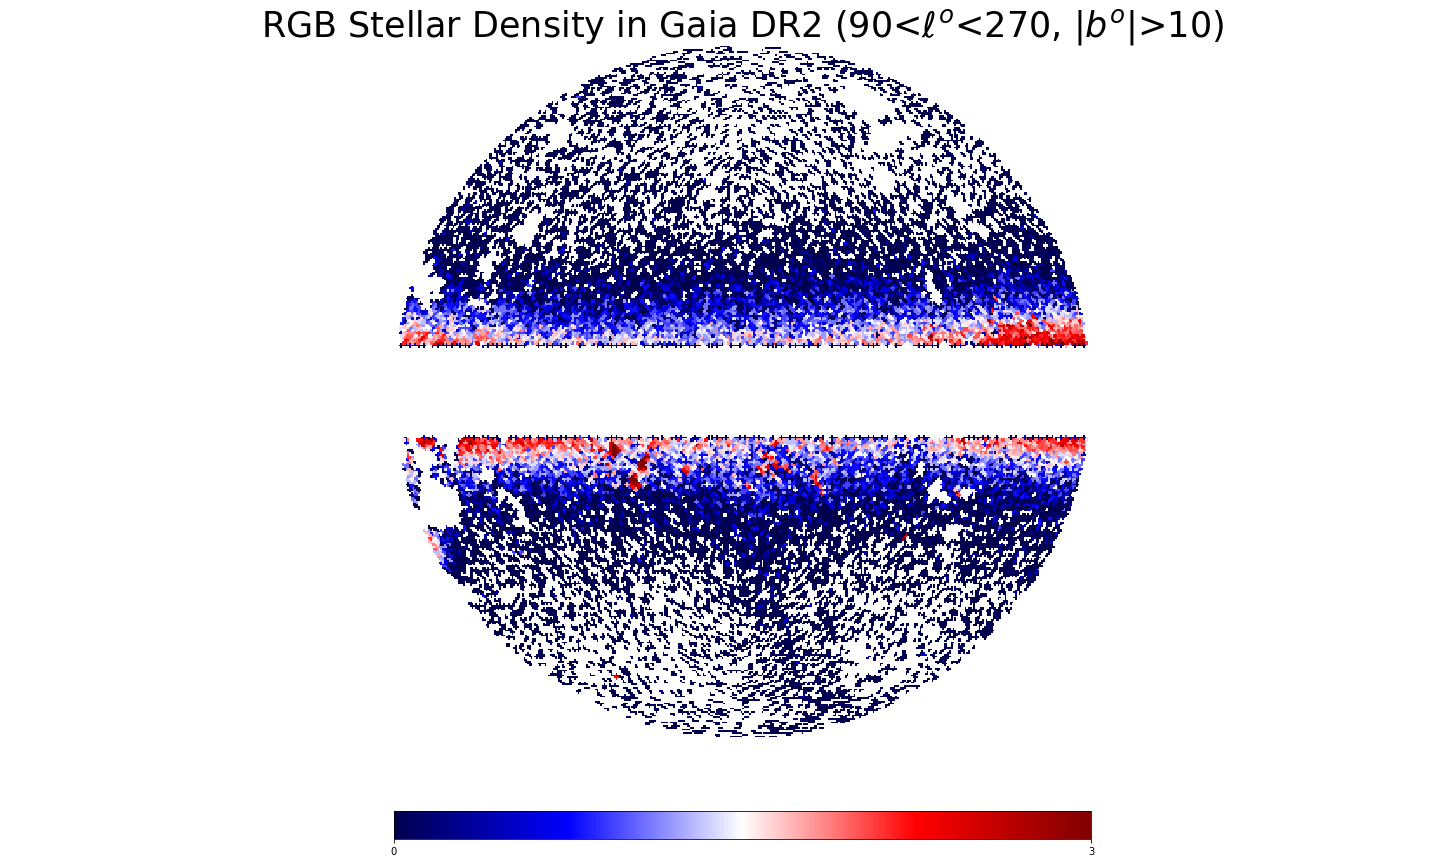

In [8]:
# Create Healpy projection 
hpx_map = cat2hpx(l-180, b, nside=75, radec=False)

plt.figure(figsize=(25,25))
plt.grid(True, color='k', lw=22)
test = hp.mollview(np.log(hpx_map), cmap='seismic', hold=True,min=0, max=3, flip='astro', remove_dip=False,
                   remove_mono=True )
plt.title('RGB Stellar Density in Gaia DR2 (90<$\ell^{o}$<270, |$b^{o}$|>10)', size=35)

## Section 1.1 - Investigating Number Density Profiles at Different Lines of Sight

   ### Derivation of Number Density with Expandable Radii : 

To estimate any significant density profile in the Galactic Anticenter, we need to account for the changing area (assuming we're working in spherical coordinates), and generally to keep the standard error < 10%, we derive a number density relation to account for the geometrical density effects:

Generally, for a volume element in spherical coordinates: 
$$\begin{equation} V = \int{} \int{}\int{} d V\end{equation}$$


The volume element (or "chunck") in the sperical coordinates is described by the following relation:

$$\begin{equation} V = r^{2} sin(\theta) d\theta d\phi dr \end{equation}$$

Thus in Galactic coordinates, the above equation can be changed to:

$$\begin{equation} V(r) = r^{2}*\delta r*cos(b)*\Delta b \Delta \ell  \end{equation}$$


with __$\delta r$__ being the radial bin width. 

Finally, the number density then will be: 

$$\begin{equation} \rho_{Mg} = \frac{N^{'}}{V}\end{equation}$$

where $N^{'}$ being the number of stars in each bin and $\rho_{Mg}$ has units of [number of stars $\times$ $kpc^{-3}$ $\times$ $deg^-2$]

To calculate this in our data, we can perform the following analysis: 
 - Utilize `galactic_binner.distance_binner()` to bin the distance data by a minimum star per bin threshold
 - Use `galactic_binner.numner_density()` to compute the number density for the specific binning profile and utlizing the equations from above

In [18]:
# Monoceros/GASS Stellar Substructure 
min_distance = 0
max_distance = 40 

GASS_field = np.where((l>140) & (l<210) & (b>15) & (b<45) & (dist>min_distance) & (dist<max_distance))

In [19]:
from binning_mw import galactic_binner 

# Create galactic_binner object
stars_bin = galactic_binner(dist[GASS_field], l[GASS_field], b[GASS_field])

# Compute bin profile 
bin_profile = stars_bin.distance_binner(min_dist=0, max_dist=40, dr=1.5, breath_factor=0.7, star_limit=50)

# Estimate number density
n_density = stars_bin.number_density(min_dist=0, max_dist=40, dr=1.5, breath_factor=0.7, star_limit=50)

Text(0,0.5,'$\\mu_{b}$ [mas/yr]')

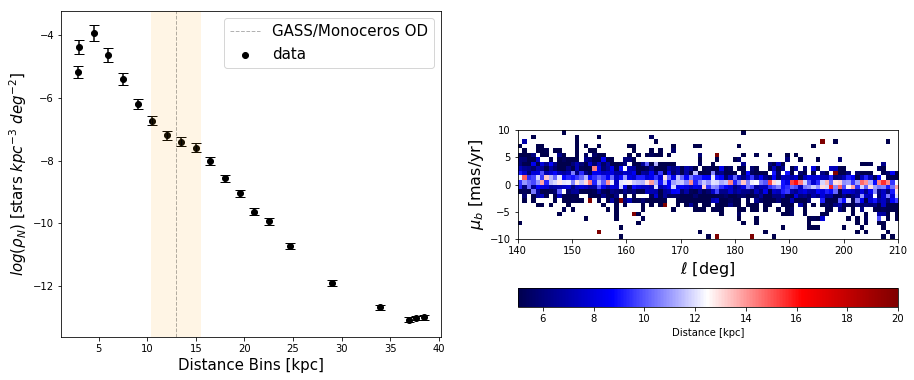

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax[0].scatter(bin_profile['dist_scan'], np.log(n_density), color='k', label='data')
ax[0].errorbar(bin_profile['dist_scan'], np.log(n_density), (1/np.log(n_density)), fmt='|', capsize=5,
           color='k', label='')
ax[0].set_ylabel('$log(ρ_{N})$ [stars $kpc^{-3}$ $deg^{-2}$]', size=15)
ax[0].set_xlabel('Distance Bins [kpc]', size=15)
ax[0].axvline(13, color='orange', lw=50, alpha=0.1)
ax[0].axvline(13, color='k', lw=1, alpha=0.3, ls='--', label='GASS/Monoceros OD')
ax[0].legend(fontsize=15)

# Select the overdensity (OD) -- reporeted distance values by Sheffield et al. 2017
mon_bump = np.where((l>140) & (l<210) & (b>15) & (b<45) & (dist>10) & (dist<16))

l_bins = np.arange(140, 210, step=0.8) # bins in l 
v_bins = np.arange(-10, 10, step=0.8) # bins in b 

# Bin 3D data 
den_v = stats.binned_statistic_2d(mu_b[GASS_field], l[GASS_field], dist[GASS_field], 'mean',
                                 bins=(v_bins, l_bins))

plt_1 = ax[1].imshow((den_v[0]), extent=[140, 210, -10, 10], aspect='equal', origin='lower', cmap='seismic',
            vmin=5, vmax=20)
fig.colorbar(plt_1, ax=ax[1], orientation='horizontal', label='Distance [kpc]')
ax[1].set_xlabel('$\ell$ [deg]', size=16)
ax[1].set_ylabel('$\mu_{b}$ [mas/yr]', size=16)